In [67]:
from VenusOpt.simulator import Venus
from VenusOpt.utils import get_scalar, loadXy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import cross_validate
from sklearn.utils import shuffle
import numpy as np

from bayes_opt import BayesianOptimization, UtilityFunction

In [83]:
exp_num = '3'
X, y, X_var = loadXy("../New Data/accumulated_weekend_data.h5", run_idx=exp_num)
X.shape, y.shape, X_var.shape
y = y
gpr = GaussianProcessRegressor(
    alpha=X_var.mean(), n_restarts_optimizer=9
)

X, y = shuffle(X, y)
print(cross_validate(gpr, X, y))

gpr.fit(X, y)

{'fit_time': array([0.03001189, 0.02941179, 0.02781296, 0.02746773, 0.02923512]), 'score_time': array([0.00437641, 0.00583839, 0.0062232 , 0.00431204, 0.00521517]), 'test_score': array([0.65956743, 0.52060216, 0.57593234, 0.50556546, 0.54235385])}


GaussianProcessRegressor(alpha=0.0009060408920488076, n_restarts_optimizer=9)

In [85]:
x_scalar = get_scalar()
x_scalar

array([0.07692308, 0.07692308, 0.06666667])

In [86]:
gpr.predict(x_scalar * np.array([105,105,120]).reshape(1,-1))

array([-0.00012012])

In [87]:
unnormalized_gpr = lambda arr: (-gpr.predict((arr * x_scalar).reshape(1,-1)) * 1000000)[0]
venus = Venus(jitter=0.15, func=unnormalized_gpr)

In [88]:
venus.set_mag_currents(105,105,120)
venus.get_beam_current()

120.11905760229979

In [89]:
pbounds = {"A": [97, 110], "B": [97, 110], "C": [116, 128]}

def get_black_box_func(venus):
    # Define the black box function to optimize.
    def black_box_function(A, B, C):
        # C: SVC hyper parameter to optimize for.
        venus.set_mag_currents(A, B, C)
        v = venus.get_beam_current()
        return v
    return black_box_function

def try_kappa(kappa, bbf, n=10):
    best_list = []
    for i in range(n):
        random_state = int(i+100*kappa)
        optimizer = BayesianOptimization(f = bbf,
                                     pbounds = pbounds, verbose = 0,
                                     random_state = random_state)
        optimizer.maximize(init_points = 5, n_iter = 30, kappa=kappa, alpha=0.15)
        best = optimizer.max["target"]
        best_list.append(best)
    return best_list

100%|██████████| 10/10 [12:29<00:00, 74.92s/it]


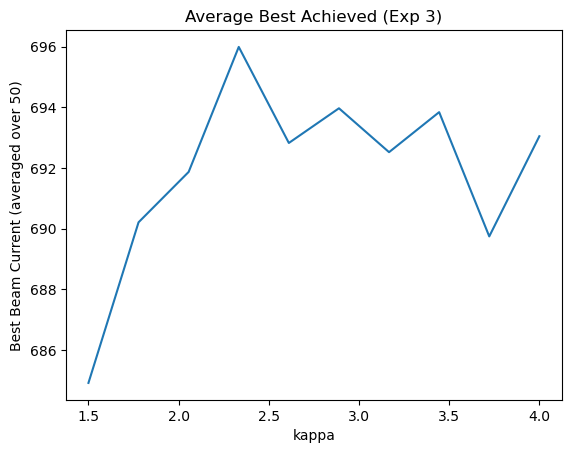

In [91]:
from tqdm import tqdm
import matplotlib.pyplot as plt
bbf = get_black_box_func(Venus(jitter=0.15, func=unnormalized_gpr))
n = 50
kappas = np.linspace(1.5, 4, 10)
results = []
for kappa in tqdm(kappas):
    best_list = try_kappa(kappa, bbf, n=n)
    results.append(sum(best_list)/len(best_list))

plt.plot(kappas, results)
plt.title("Average Best Achieved (Exp %s)"%exp_num)
plt.xlabel("kappa")
plt.ylabel("Best Beam Current (averaged over %d)"%n)
plt.show()